In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

# [NetworkX](https://networkx.org/)

* [most popular](https://pypistats.org/packages/networkx) graph analytics library
* easy-to-use API
* [documentation](https://networkx.org/documentation/stable/index.html) with examples
* **tradeoff** is performance





### **NVIDIA RAPIDS cuGraph** Backend

* NetworkX version >= 3 introduced backends
* nx-cugraph : GPU acceleration, unchanged API

In [ ]:
!pip list | grep -E 'networkx|cugraph'

networkx                           3.4.2
nx-cugraph-cu12                    24.10.0
pylibcugraph-cu12                  24.10.0


### Numuerous ways to configure NVIDIA RAPIDS cuGraph

In [ ]:
# export NETWORKX_AUTOMATIC_BACKENDS=cugraph

# %set_env NETWORKX_AUTOMATIC_BACKENDS=cugraph

# nx.config.backend_priority=["cugraph"]  # NETWORKX_BACKEND_PRIORITY=cugraph

<br/>

---

# Graph 1 : [Zachary's Karate Club](https://en.wikipedia.org/wiki/Zachary%27s_karate_club)
* 34 nodes

### Use networkx version >= 3.4.*

In [ ]:
import matplotlib.pyplot as plt

import networkx as nx

nx.__version__

'3.4.2'

In [ ]:
G = nx.karate_club_graph()
G.number_of_nodes(), G.number_of_edges()

(34, 78)

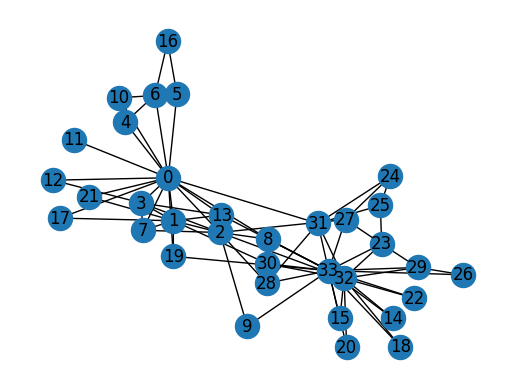

In [ ]:
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos)
nx.draw_networkx_edges(G, pos)
nx.draw_networkx_labels(G, pos)
# plt.tight_layout()
plt.axis("off")
plt.show()

<br/>

---

# Algo 1 : [Betweenness Centrality](https://en.wikipedia.org/wiki/Betweenness_centrality)  

* for each node (`v`), count of shortest paths between node pairs that pass through `v`
* ie, count of connections between other nodes
* higher count equals higher centrality

In [ ]:
nx_bc_results = nx.betweenness_centrality(G)

In [ ]:
nx.set_node_attributes(G, nx_bc_results, "nx_bc")

In [ ]:
nx_bc_results

{0: 0.43763528138528146,
 1: 0.053936688311688304,
 2: 0.14365680615680618,
 3: 0.011909271284271283,
 4: 0.0006313131313131313,
 5: 0.02998737373737374,
 6: 0.029987373737373736,
 7: 0.0,
 8: 0.05592682780182781,
 9: 0.0008477633477633478,
 10: 0.0006313131313131313,
 11: 0.0,
 12: 0.0,
 13: 0.04586339586339586,
 14: 0.0,
 15: 0.0,
 16: 0.0,
 17: 0.0,
 18: 0.0,
 19: 0.03247504810004811,
 20: 0.0,
 21: 0.0,
 22: 0.0,
 23: 0.017613636363636363,
 24: 0.0022095959595959595,
 25: 0.0038404882154882154,
 26: 0.0,
 27: 0.02233345358345358,
 28: 0.0017947330447330447,
 29: 0.0029220779220779218,
 30: 0.014411976911976909,
 31: 0.13827561327561325,
 32: 0.145247113997114,
 33: 0.30407497594997596}

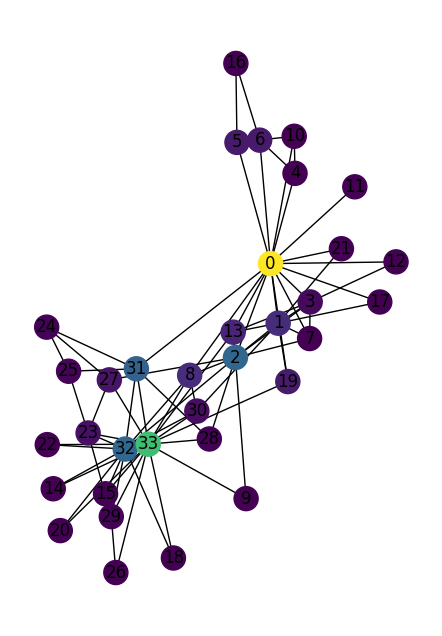

In [ ]:
# Configure plot size and layout/position for each node
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
pos = nx.spring_layout(G)

# Assign colors for each set of betweenness centrality results
nx_colors = [G.nodes[n]["nx_bc"] for n in G.nodes()]

# Plot the graph and color each node corresponding to NetworkX betweenness centrality values
plt.subplot(1, 2, 1)
nx.draw(G, pos=pos, with_labels=True, node_color=nx_colors)

* `0` and `33` are the most central
* followed by `2`, `31`, and `32`.

<br/>

---

# Algo 2 : [PageRank](https://en.wikipedia.org/wiki/PageRank) Link Analysis

In [ ]:
nx_pr_results = nx.pagerank(G)

In [ ]:
nx.set_node_attributes(G, nx_pr_results, "nx_pr")

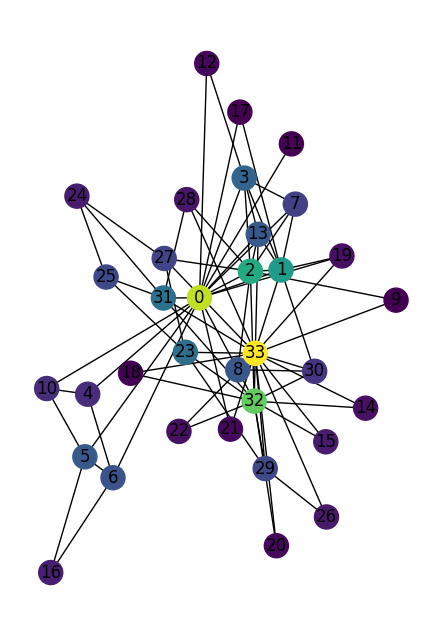

In [ ]:
# Configure plot size and layout/position for each node
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
pos = nx.spring_layout(G)

# Assign colors for each set of betweenness centrality results
nx_colors = [G.nodes[n]["nx_pr"] for n in G.nodes()]

# Plot the graph and color each node corresponding to NetworkX betweenness centrality values
plt.subplot(1, 2, 1)
nx.draw(G, pos=pos, with_labels=True, node_color=nx_colors)

<br/>

---
# Graph 2 : [US Patent Citations](https://snap.stanford.edu/data/cit-Patents.html) (16.5M / 3.8M)

In [ ]:
# The locale encoding may have been modified from the plots above, reset here to run shell commands
# import locale
# locale.getpreferredencoding = lambda: "UTF-8"
!wget https://snap.stanford.edu/data/cit-Patents.txt.gz  # Skip if cit-Patents.txt.gz already exists.

--2024-11-05 22:31:01--  https://snap.stanford.edu/data/cit-Patents.txt.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85139832 (81M) [application/x-gzip]
Saving to: ‘cit-Patents.txt.gz.1’

cit-Patents.txt.gz. 100%[===================>]  81.20M  18.6MB/s    in 8.6s    

2024-11-05 22:31:10 (9.44 MB/s) - ‘cit-Patents.txt.gz.1’ saved [85139832/85139832]



<br/>

---
### **RAPIDS OFF** - load data

In [ ]:
import pandas as pd

In [ ]:
%%time
# 4.53 s
df = pd.read_csv("cit-Patents.txt.gz",
                 compression="gzip",
                 skiprows=4,
                 sep="\t",
                 names=["src", "dst"],
                 dtype="int32",
)

CPU times: user 4.38 s, sys: 155 ms, total: 4.54 s
Wall time: 4.52 s


---

### **RAPIDS ON** - load data

In [ ]:
%load_ext cudf.pandas
import pandas as pd

In [ ]:
%%time
# 1.78
df = pd.read_csv("cit-Patents.txt.gz",
                 compression="gzip",
                 skiprows=4,
                 sep="\t",
                 names=["src", "dst"],
                 dtype="int32",
)

CPU times: user 1.3 s, sys: 318 ms, total: 1.61 s
Wall time: 1.67 s


---
### Load Graph

In [ ]:
%%time
!date
# 51-56s

G = nx.from_pandas_edgelist(df, source="src", target="dst")
G.number_of_nodes(), G.number_of_edges()

Tue Nov  5 10:32:22 PM UTC 2024
CPU times: user 51.1 s, sys: 2.81 s, total: 53.9 s
Wall time: 52.6 s


(3774768, 16518948)

In [ ]:
len(
    set(
        list(df["src"].unique()) +
        list(df["dst"].unique())
        )
    )

3774768

In [ ]:
df.sort_values(["src", "dst"]).head(3)

,src,dst
0,3858241,956203
1,3858241,1324234
2,3858241,3398406


<br/>

<br/>

<br/>

# **RAPIDS ON/OFF**

---
### Cache
* cache graph object in different structures

In [ ]:
import warnings
warnings.filterwarnings("ignore")

nx.config.cache_converted_graphs=True   # NETWORKX_CACHE_CONVERTED_GRAPHS=True

<br/>

---
### **RAPIDS OFF** - betweenness & PageRank

In [ ]:
nx.config.backend_priority = []

### Betweeness Centrality

In [ ]:
%%time
!date
# 59s-69s

bc_results = nx.betweenness_centrality(G, k=1)

Tue Nov  5 10:46:55 PM UTC 2024
CPU times: user 1min 2s, sys: 839 ms, total: 1min 2s
Wall time: 1min 1s


### PageRank

In [ ]:
%%time
!date
# 93s-101s

nx_pr_results = nx.pagerank(G)

Tue Nov  5 10:48:09 PM UTC 2024
CPU times: user 1min 39s, sys: 4.03 s, total: 1min 43s
Wall time: 1min 40s


---
### **RAPIDS ON** - betweenness & PageRank

In [ ]:
# export NETWORKX_AUTOMATIC_BACKENDS=cugraph
nx.config.backend_priority=["cugraph"]  # NETWORKX_BACKEND_PRIORITY=cugraph

### Betweenness Centrality

In [ ]:
%%time
# 24s X 4 SPEEDUP
!date

# k sampling; accuracy tradeoff
bc_results_cu = nx.betweenness_centrality(G, k=1)

Tue Nov  5 10:50:25 PM UTC 2024
CPU times: user 23.4 s, sys: 995 ms, total: 24.4 s
Wall time: 24.9 s


In [ ]:
%%time
# 1.34 X 72 SPEEDUP
!date

# k sampling; accuracy tradeoff
bc_results_cu = nx.betweenness_centrality(G, k=1)

Tue Nov  5 10:51:00 PM UTC 2024
CPU times: user 1.11 s, sys: 304 ms, total: 1.42 s
Wall time: 1.48 s


### PageRank

In [ ]:
%%time
!date
# 31s X 3 SPEEDUP

nxcg_pr_results = nx.pagerank(G, backend="cugraph")

Tue Nov  5 10:51:16 PM UTC 2024
CPU times: user 30.4 s, sys: 1.24 s, total: 31.7 s
Wall time: 30.8 s


In [ ]:
%%time
!date
# 1.39 X 71 SPEEDUP

nxcg_pr_results = nx.pagerank(G, backend="cugraph")

Tue Nov  5 10:51:46 PM UTC 2024
CPU times: user 1.04 s, sys: 313 ms, total: 1.36 s
Wall time: 1.42 s


### k = n

In [ ]:
%%time
!date
# 5 seconds

bc_results_cu_k1000 = nx.betweenness_centrality(G, k=100)

Tue Nov  5 10:52:01 PM UTC 2024
CPU times: user 5.45 s, sys: 654 ms, total: 6.1 s
Wall time: 5.72 s


<br/>

---
<i>
Each user is responsible for checking the content of datasets and the applicable licenses and determining if suitable for the intended use.
<i>
<br>
<br>
<i>
Information on the U.S. Patent Citation Network dataset used in this notebook is as follows:
<br>Authors: Jure Leskovec and Andrej Krevl
<br>Title: SNAP Datasets, Stanford Large Network Dataset Collection
<br>URL: http://snap.stanford.edu/data
<br>Date: June 2014
</i>
